In [152]:
dataDir= "D:/Autonomous Vehicle/Code1/location-2"

In [153]:
#exec(open('init_notebook.py').read())
exec(open('D:/Autonomous Vehicle/Code2/behavior-hypotheses/src/notebooks/init_notebook.py').read())

current working dirD:\Autonomous Vehicle\Code2\behavior-hypotheses\src


In [154]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.interpolate import interp1d

from tabulate import tabulate
from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [155]:
sceneId=210
date="2023-05-04"
fps=10
minYDisplacement=5
maxXDisplacement=6
pedDf=pd.read_csv(os.path.join(dataDir,f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf=pd.read_csv(os.path.join(dataDir,f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta=pd.read_csv(os.path.join(dataDir,f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [156]:
visualizer=TrajectoryVisualizer()
adeCalculator=TrajectoryADECalculator()
colMapper= ColMapper(idCol='uniqueTrackId',
                     xCol='sceneX',
                     yCol='sceneY',
                     xVelCol='sceneXVelocity',
                     yVelCol='sceneYVelocity',
                     speedCol='speed',
                     fps=fps
                     )
transformer=TrajectoryTransformer(colMapper)
cleaner=TrajectoryCleaner(colMapper=colMapper,
                          minSpeed=0.0,
                          maxSpeed=3.5,
                          minYDisplacement=minYDisplacement,
                          maxXDisplacement=maxXDisplacement)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)

In [157]:
cleanPedDf=cleaner.cleanByYDisplacement(pedDf)
#visualizer.show(pedDf,idCol='uniqueTrackId',xCol='sceneX',yCol='sceneY')
#visualizer.show(cleanPedDf,idCol='uniqueTrackId',xCol='sceneX',yCol='sceneY')
#print(cleanPedDf)
allPedIds=list(cleanPedDf["uniqueTrackId"].unique())
#print(allPedIds)->Gives the unique ids
transformer.translateAllToLocalSource(cleanPedDf)# Creates two new columns localX,localY which gives the values of points with resopect to one single origin
#print(cleanPedDf)
#visualizer.show(cleanPedDf,idCol="uniqueTrackId",xCol="localX",yCol="localY")

southIds=[]
for pedId in allPedIds:
        trackDf=cleanPedDf[cleanPedDf['uniqueTrackId']==pedId]
        trackMeta=tracksMeta[tracksMeta['uniqueTrackId']==pedId].iloc[0]
        
        if trackMeta['verticalDirection']=="SOUTH":
                southIds.append(pedId)
                X,Y=transformer.rotate180(trackDf,'localX','localY')
                cleanPedDf.loc[cleanPedDf['uniqueTrackId']==pedId,'localX']=X
                cleanPedDf.loc[cleanPedDf['uniqueTrackId']==pedId,'localY']=Y
#visualizer.show(cleanPedDf,idCol='uniqueTrackId',xCol='localX',yCol='localY')
print(allPedIds)

using min Y displacement (5)
[18023, 18069, 18090, 18121, 18134, 18162, 18168, 18181, 18214, 18225, 18279, 18298, 18304, 18311, 18344, 18382, 18420, 19045, 19055, 19059, 19140, 19199, 19205, 19235, 19243, 19320, 19346, 20023, 20048, 20052, 20054, 20078, 20083, 20087, 20098, 20099, 20100, 20136, 20156, 20219, 20229, 20261, 20263, 20287, 20296, 20323, 20327, 20351, 20362, 20369, 20376, 20389, 20418, 20475, 21035, 21040, 21057, 21059, 21068, 21087, 21089, 21115, 21116, 21125, 21169, 21170, 21172, 21187, 21269, 21286, 21303, 21404, 21408, 21413, 21414, 21472, 21496, 21521, 21522, 22005, 22078, 22118, 22151, 22171, 22202, 22204, 22251, 22288, 22295, 22297, 22298, 22372, 22444, 22451, 22491, 22499, 23001, 23033, 23061, 23101, 23147, 23150, 23156, 23188, 23207, 23210, 23235, 23248, 23249, 23273, 23274, 23404, 23410, 23431, 23479, 24050, 24063, 24064, 2406500, 24122, 24132, 24167, 24181, 24276, 24291, 24295, 24388, 25052, 25074, 25093, 25170, 25205, 25240, 25245, 25246, 25261, 25318, 25348, 25

In [158]:
## collect localXe and localYe
trackIds = cleanPedDf["uniqueTrackId"].unique()
localXe=[]
localYe=[]

for trackId in trackIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == trackId]
    
    #collect and append the localX and localY values in a list
    localXe.append(trackDf["localX"].tolist())
    localYe.append(trackDf["localY"].tolist())


In [159]:
def calculate_threshold(points) :
        i=0
        sum=0
        size=len(points)
        for i in range(size-1) :
                sum=sum+abs(points[i][0]-points[i+1][0])
        return abs(sum)/size

In [160]:
def rdp(points, epsilon):
    """
    Reduce the number of points in a curve using the Ramer-Douglas-Peucker algorithm.
    Parameters:
    - points: Nx2 array of x and y coordinates.
    - epsilon: Tolerance parameter.
    Returns:
    - Reduced set of points.
    """
    # Find the point with the maximum distance from the line between start and end
    start, end = points[0], points[-1]
    line_vec = end - start
    line_vec_norm = line_vec / np.hypot(*line_vec)
    distances = np.abs(np.cross(points - start, line_vec_norm))
    
    
    max_distance = np.max(distances)
    index = np.argmax(distances)
    
    
    # If the max distance is greater than epsilon, recursively simplify
    if max_distance > epsilon:
        left = rdp(points[:index+1], epsilon)
        right = rdp(points[index:], epsilon)
        return np.vstack((left[:-1], right))
    else:
        return np.array([start, end])

In [161]:
def rdp_limited(points, max_nodes, initial_epsilon, step):
    epsilon = initial_epsilon
    while True:
        reduced_points = rdp(points, epsilon)
        if len(reduced_points) <= max_nodes:
            return reduced_points
        else:
            epsilon += step  # Simplify more by increasing epsilon
        

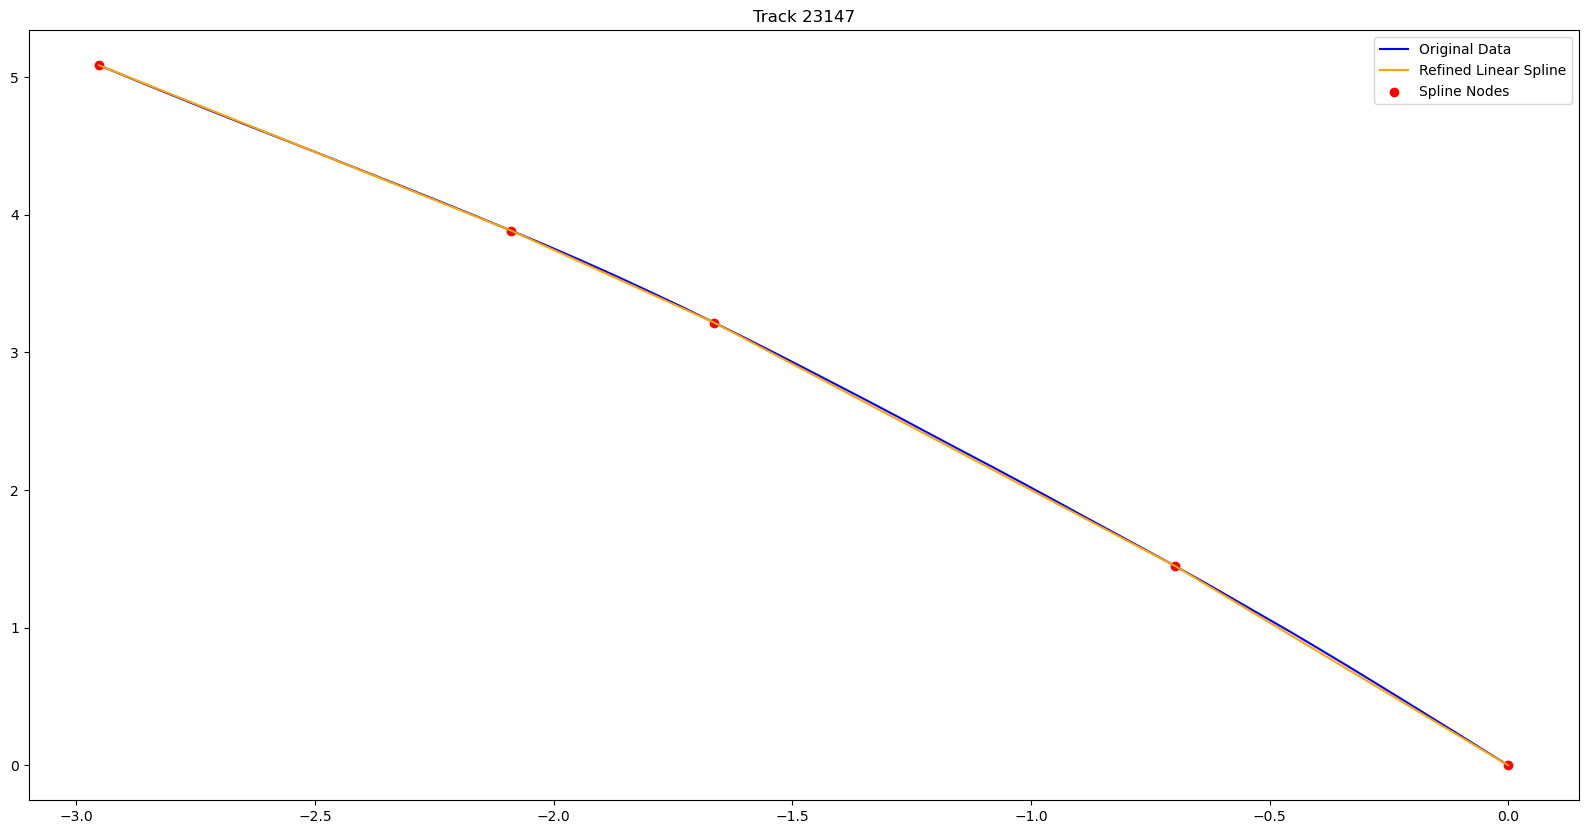

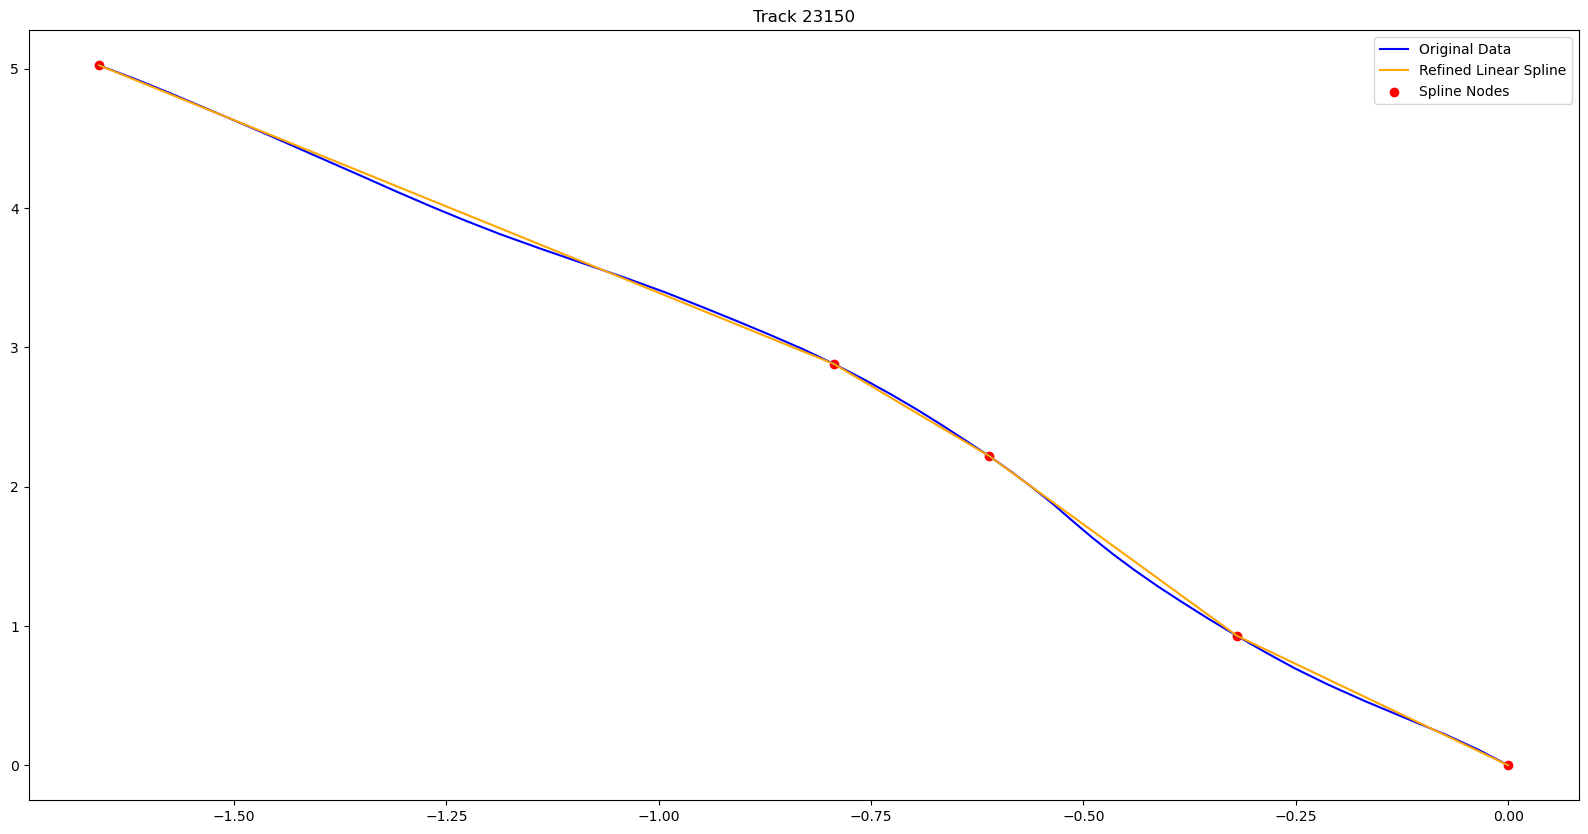

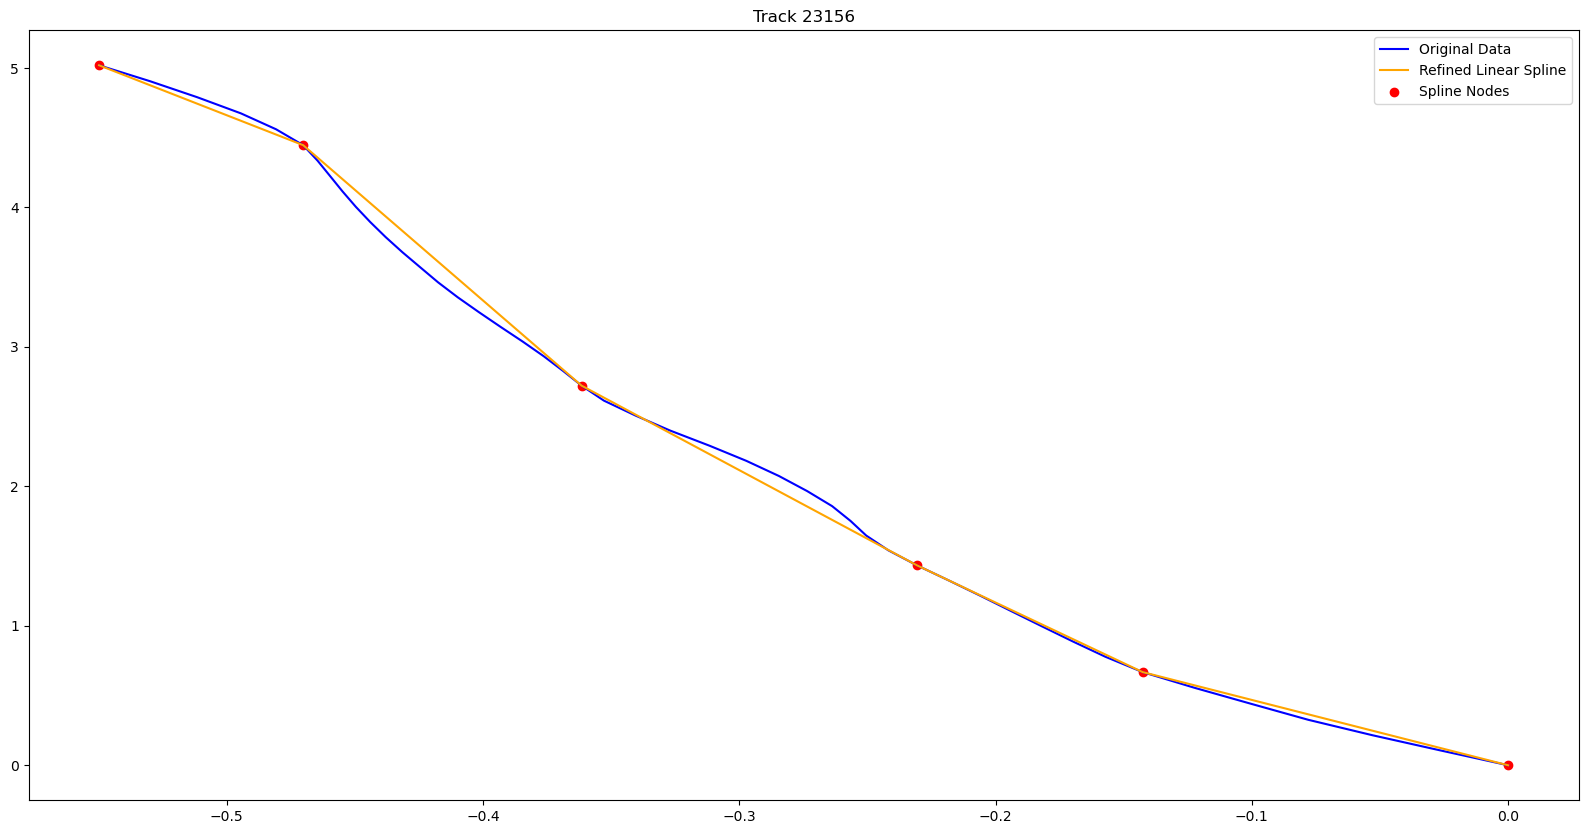

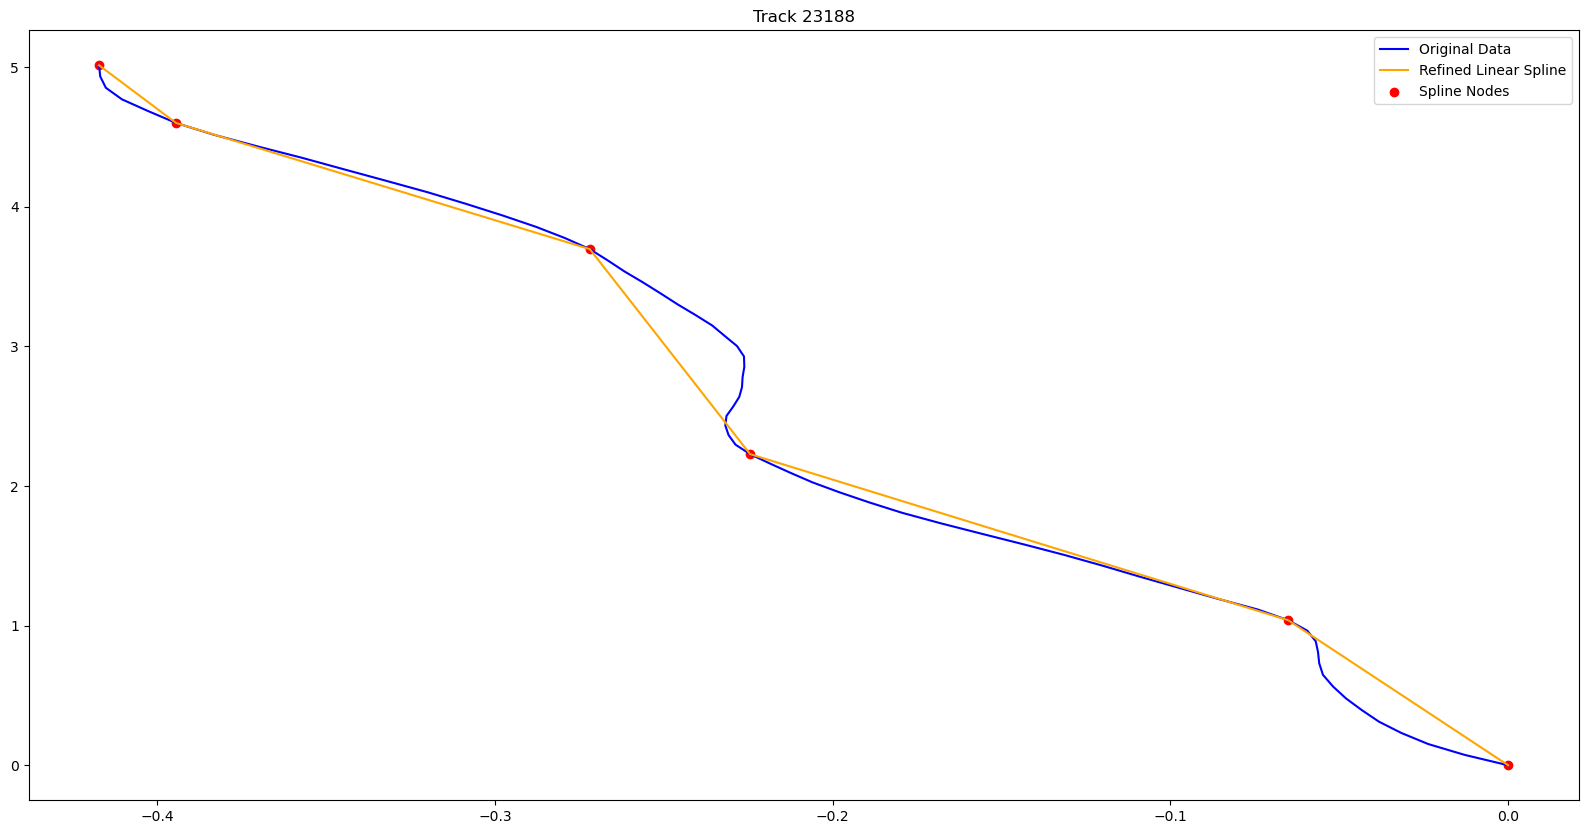

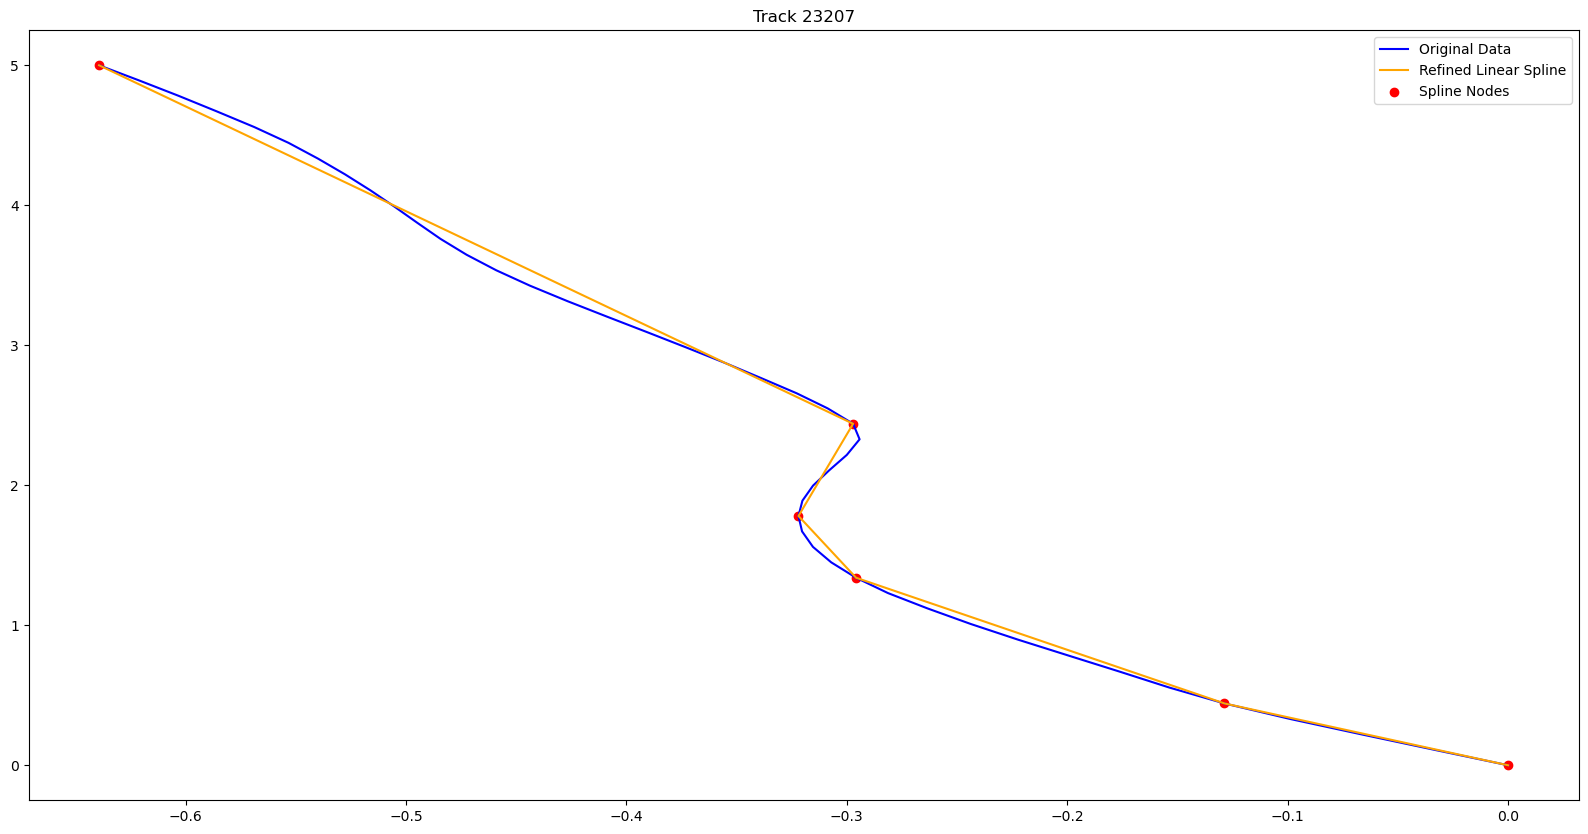

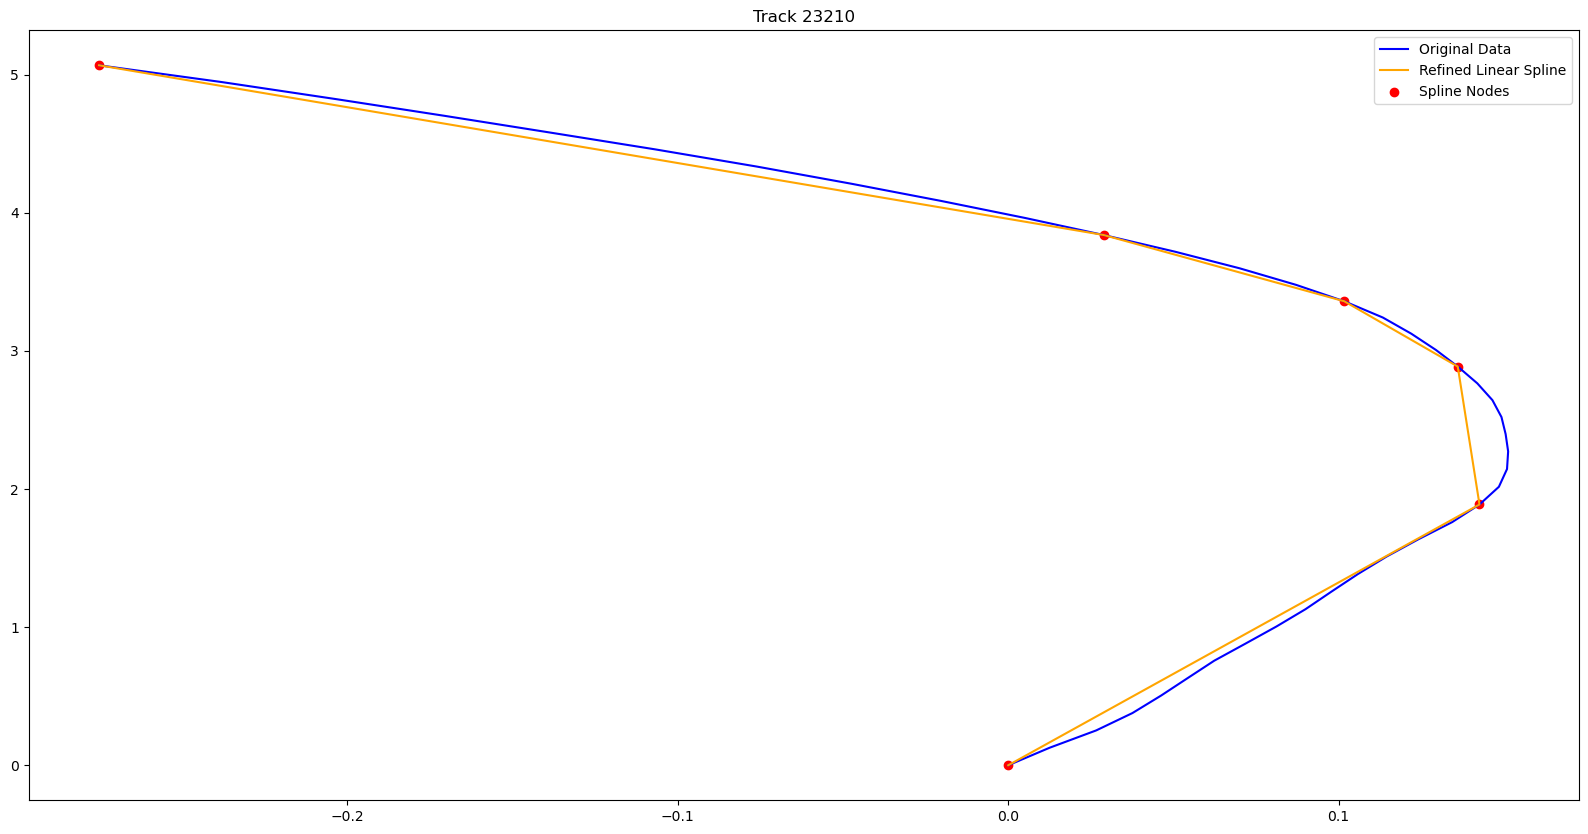

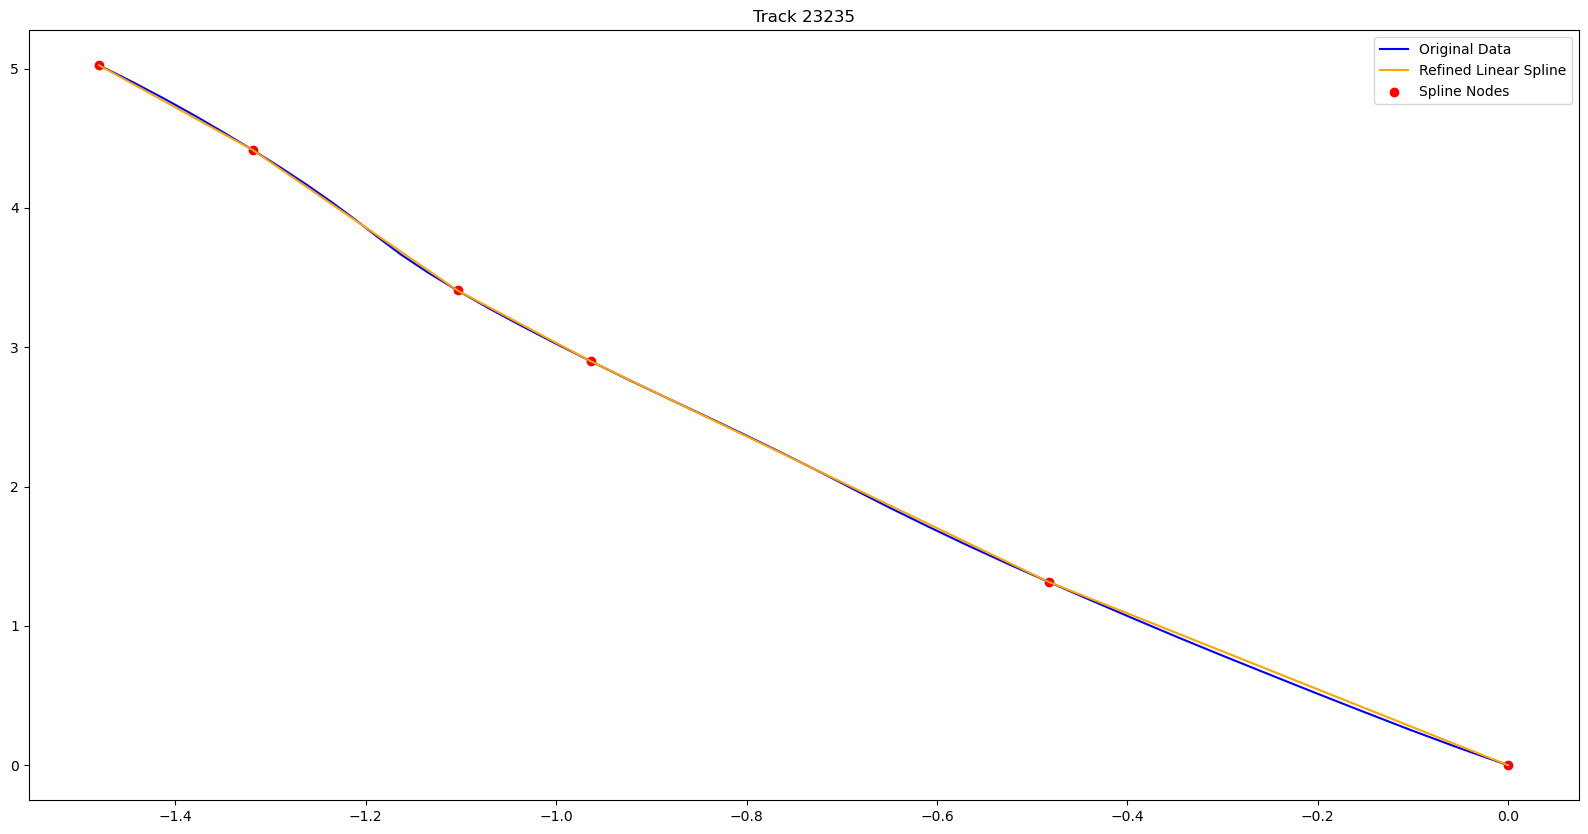

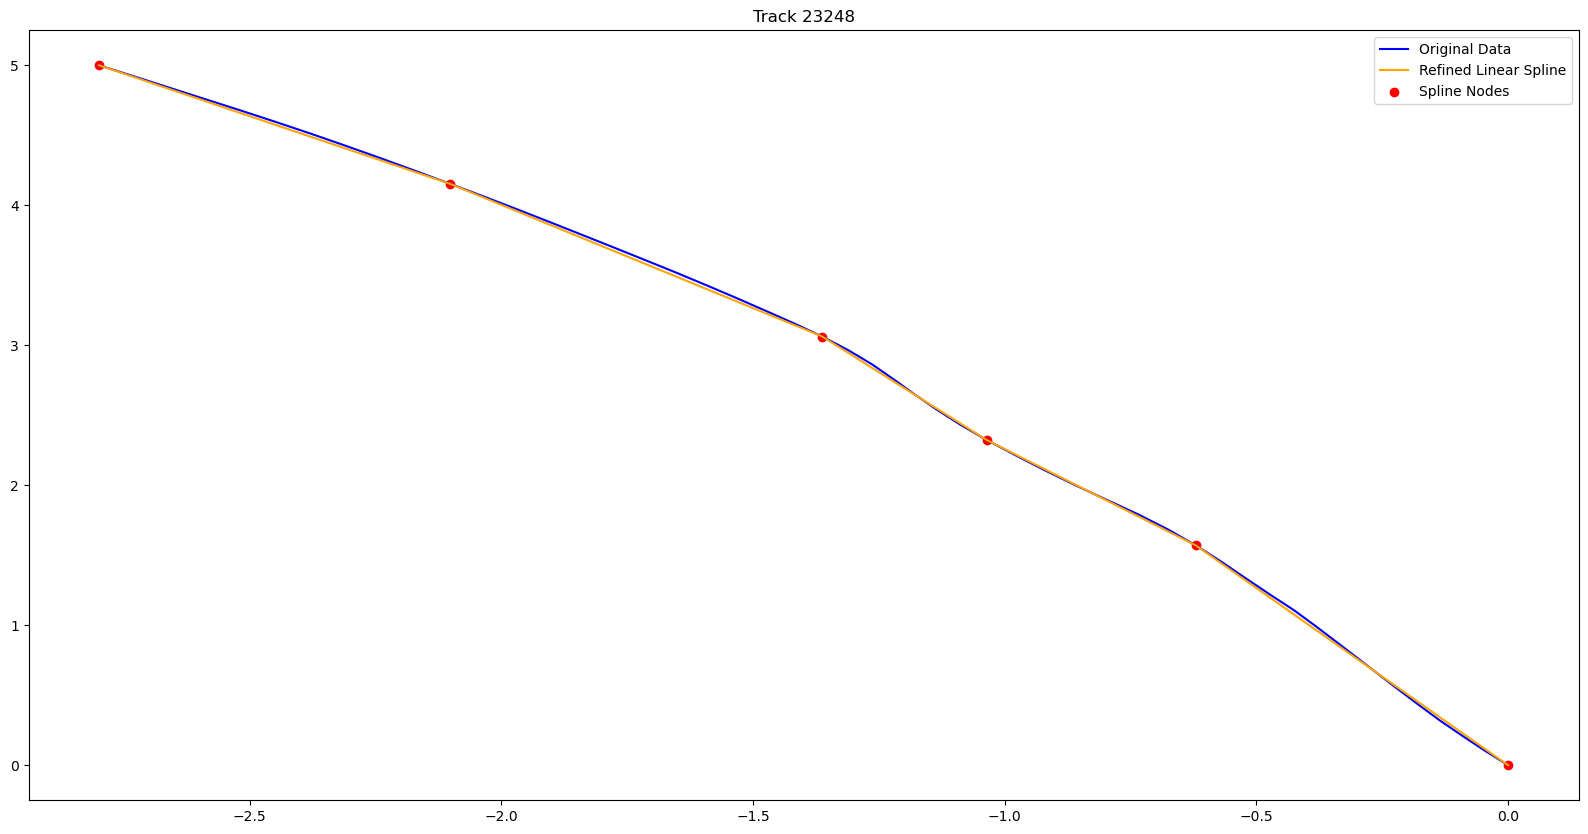

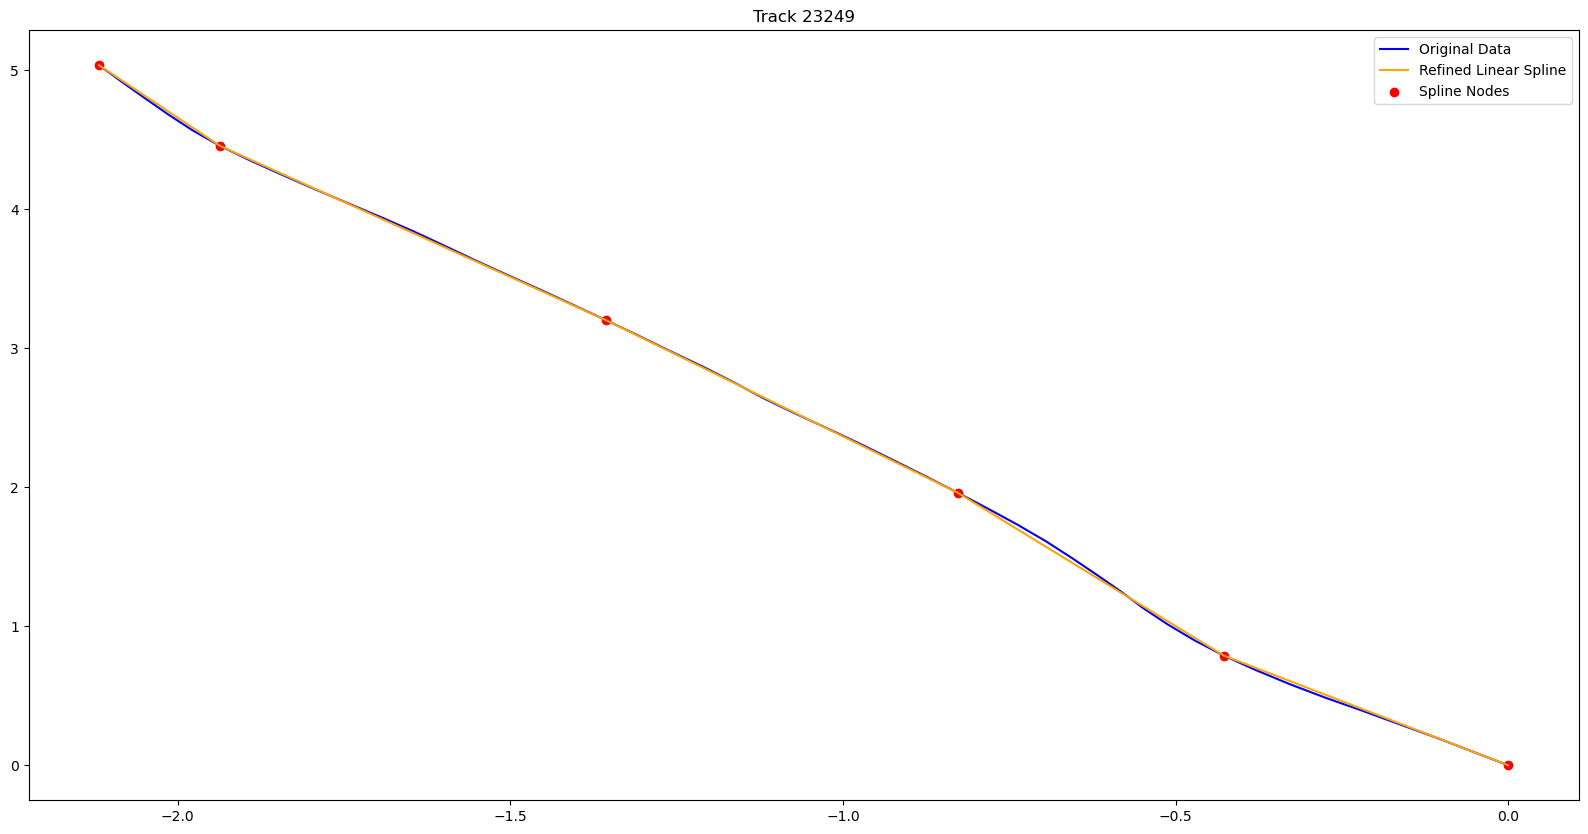

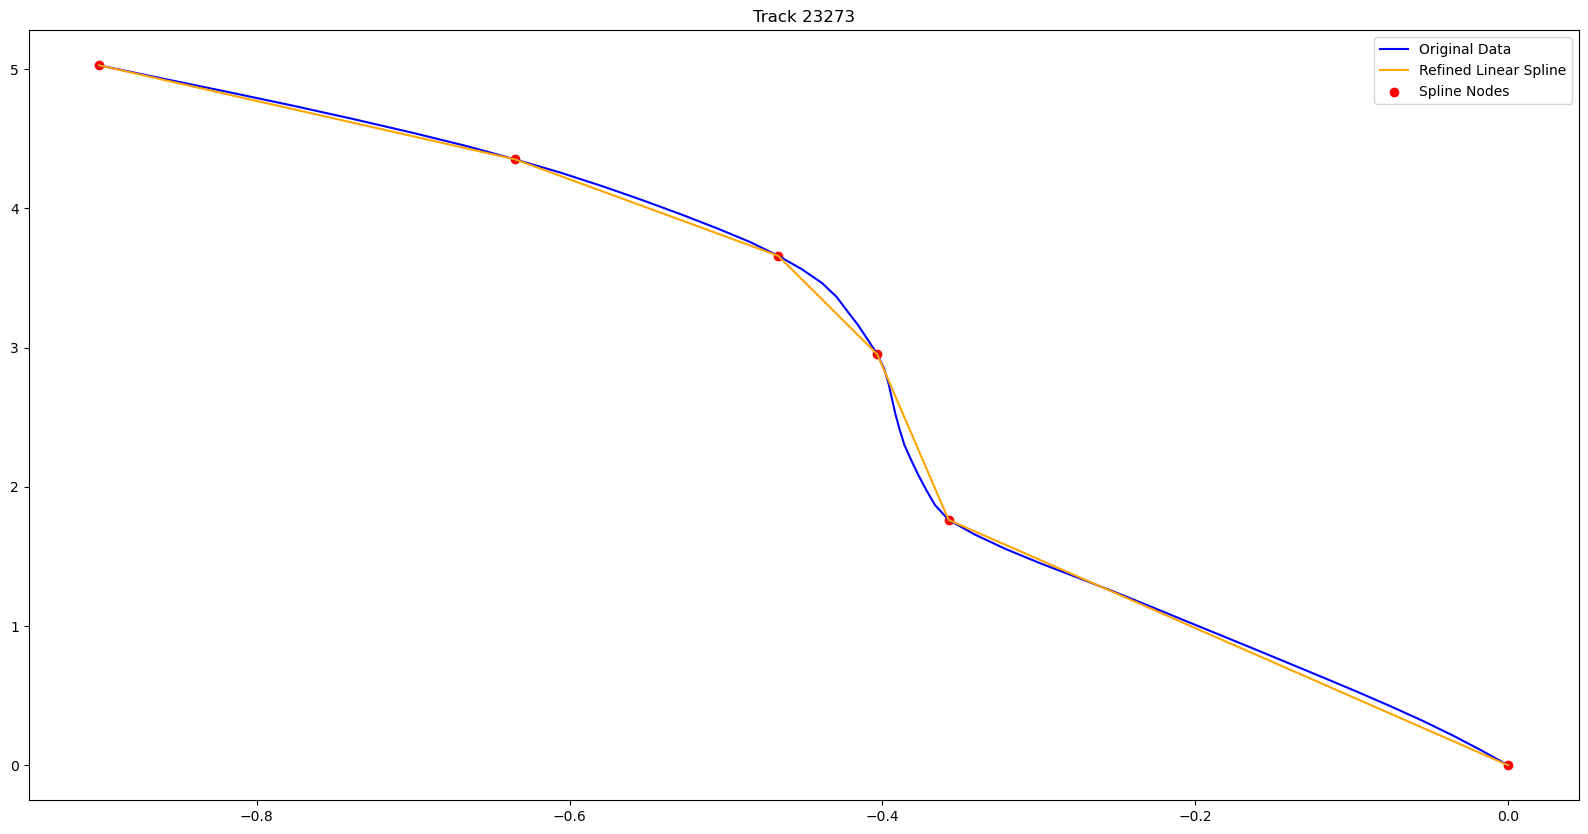

In [162]:

## main algo

for i in range(100,110):
    dataX = (np.array(localXe[i]))
    dataY = (np.array(localYe[i]))
    points= np.column_stack((dataX, dataY))
    max_nodes=8
    epsilon = calculate_threshold(points)/5
    step=epsilon/2
    reduced_points = rdp_limited(points,max_nodes, epsilon,step)
    x_nodes = reduced_points[:, 0]
    y_nodes = reduced_points[:, 1]

    plt.figure(figsize=(20,10))
    plt.title(f"Track {allPedIds[i]}")
    plt.plot(dataX, dataY, label='Original Data', color='blue')
    plt.plot(x_nodes, y_nodes, label='Refined Linear Spline', color='orange')
    plt.scatter(x_nodes, y_nodes, color='red', label='Spline Nodes')
    plt.legend()

plt.show()